In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
device = 'cpu'
parallel_scan = device == 'gpu'
jax.config.update('jax_default_device', device)
# jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')

# Testing Dynamic Factor Analysis (DFA)

In [7]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import equinox as eqx
import time
from fastprogress.fastprogress import progress_bar

from jax import block_until_ready

from sppcax.models import BayesianDynamicFactorAnalysis as BDFA
from dynamax.linear_gaussian_ssm import parallel_lgssm_smoother
from sppcax.inference.smoothing import lgssm_smoother as sppcax_smoother
from sppcax.distributions import MultivariateNormalInverseGamma as MVNIG

import matplotlib.pyplot as plt
import seaborn as sns

## 1. Generate Synthetic Data

<Axes: >

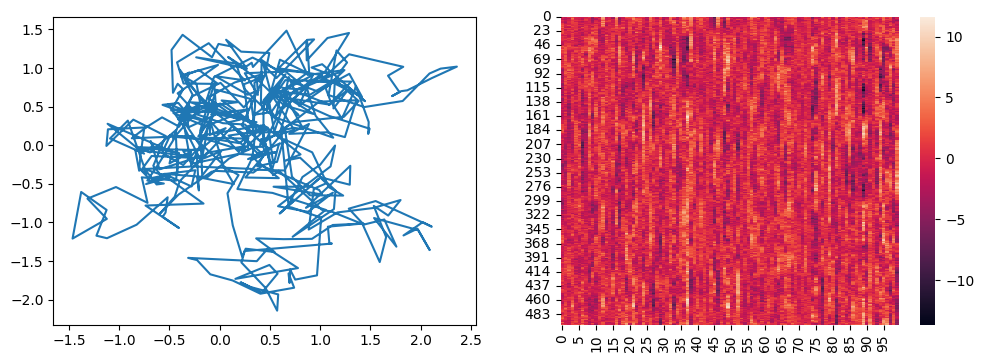

In [3]:
def generate_stable_matrix(key, dim, min_decay=0.95):
    key, _key = jr.split(key)
    Q, _ = jnp.linalg.qr(jr.normal(_key, shape=(dim, dim)))

    key, _key = jr.split(key)
    magnitudes = min_decay + jr.uniform(_key, shape=(dim,)) * (1 - min_decay)
    eigenvals = jnp.zeros(dim) + 1j * 0.0

    i = 0
    while i < dim:
        key, _key = jr.split(key)
        mag = magnitudes[i]
        if i < dim - 1 and jr.uniform(_key) > 0.5:
            angle = (jr.uniform(_key) - .5) * jnp.pi / 2
            eigenvals = eigenvals.at[i].set(mag * jnp.exp(1j * angle))
            eigenvals = eigenvals.at[i + 1].set(mag * jnp.exp(-1j * angle))
            i += 2
        else:
            eigenvals = eigenvals.at[i].set(mag * jnp.exp(1j * 0))
            i += 1

    D = jnp.diag(eigenvals)
    A = Q @ D @ Q.mT.conj()

    return A.real

def generate_data(key, timesteps, dim_y, dim_z):
    # True parameters
    key, _key = jr.split(key)
    A_true = generate_stable_matrix(_key, dim_z)

    key, subkey = jr.split(key)
    Q_true_diag = jr.uniform(subkey, (dim_z,), minval=0.05, maxval=0.1)
    Q_true = jnp.diag(Q_true_diag)

    key, subkey1, subkey2 = jr.split(key, 3)
    H_true = jr.normal(subkey1, (dim_y, dim_z)) * jr.bernoulli(subkey2, p=0.3, shape=(dim_y, dim_z))
    sorted_idx = jnp.argsort(jnp.isclose(H_true, 0.0).sum(0))
    H_true = H_true[:, sorted_idx]

    key, subkey = jr.split(key)
    R_true_diag = jr.uniform(subkey, (dim_y,), minval=0.5, maxval=1.0)
    R_true = jnp.diag(R_true_diag)

    z0_true = jnp.zeros(dim_z)
    Sigma0_true = jnp.eye(dim_z)

    # Generate latent states (z) and observations (y)
    z_true = jnp.zeros((timesteps, dim_z))
    y_obs = jnp.zeros((timesteps, dim_y))

    key, subkey1, subkey2 = jr.split(key, 3)
    z_curr = jr.multivariate_normal(subkey1, z0_true, Sigma0_true)
    z_true = z_true.at[0].set(z_curr)
    y_obs = y_obs.at[0].set(jr.multivariate_normal(subkey2, H_true @ z_curr, R_true))

    for t in range(1, timesteps):
        key, subkey1, subkey2 = jr.split(key, 3)
        z_curr = jr.multivariate_normal(subkey1, A_true @ z_curr, Q_true)
        z_true = z_true.at[t].set(z_curr)
        y_obs = y_obs.at[t].set(jr.multivariate_normal(subkey2, H_true @ z_curr, R_true))

    return y_obs, z_true, (A_true, Q_true, H_true, R_true)

key = jr.PRNGKey(101)
dim_y = 100
dim_z = 20
timesteps = 500
key, _key = jr.split(key)
y_obs, z_true, params_true = generate_data(_key, timesteps, dim_y, dim_z,)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(z_true[:, 0], z_true[:, 1])
sns.heatmap(y_obs, ax=axes[1])

## 1. Runtime comparisons

In [4]:
num_repeats = 3
timings = {}
for dim_y in [10, 20, 40, 80]:
    for dim_z in [8, 12, 24, 48]:
        for timesteps in [100, 500]:
            key, model_key = jr.split(key)
            y_obs, _, params_true = generate_data(_key, timesteps, dim_y, dim_z)
            dfa_model = BDFA(dim_z, dim_y, parallel_scan=parallel_scan)

            init_params, props = dfa_model.initialize(
                model_key,
                dynamics_weights=params_true[0],
                dynamics_covariance=params_true[1],
                emission_weights=params_true[2],
                emission_covariance=params_true[3]
            )

            start = time.time()
            for _ in range(num_repeats):
                updated_params, elbos = block_until_ready(eqx.filter_jit(dfa_model.fit_em)(init_params, props, y_obs, _key, num_iters=100, verbose=False))
            end = time.time()
            mean_time1 = (end-start)/num_repeats
            
            start = time.time()
            for _ in range(num_repeats):
                block_until_ready(eqx.filter_jit(dfa_model.fit_blocked_gibbs)(_key, updated_params, props, sample_size=100, emissions=y_obs, verbose=False))
            end = time.time()
            mean_time2 = (end-start)/num_repeats

            init_params, props = dfa_model.initialize(
                model_key,
                dynamics_weights=params_true[0],
                dynamics_covariance=params_true[1],
                emission_weights=params_true[2],
                emission_covariance=params_true[3],
                variational_bayes=True
            )

            start = time.time()
            for _ in range(num_repeats):
                block_until_ready(eqx.filter_jit(dfa_model.fit_vbem)(init_params, props, y_obs, _key, num_iters=100, verbose=False))
            end = time.time()
            mean_time3 = (end-start)/num_repeats

            timings[(dim_y, dim_z, timesteps)] = (mean_time1, mean_time2, mean_time3)
            print((dim_y, dim_z, timesteps), (mean_time1, mean_time2, mean_time3))

(10, 8, 100) (0.6874815622965494, 1.5637774467468262, 0.7814676761627197)
(10, 8, 500) (1.363113562266032, 2.3939064343770347, 2.4035655657450357)
(10, 12, 100) (0.6174748738606771, 1.4559321403503418, 0.8101387023925781)
(10, 12, 500) (1.5206145445505779, 2.5377286275227866, 2.74955145517985)
(10, 24, 100) (0.8187305132548014, 1.9160443941752117, 1.1762480735778809)
(10, 24, 500) (2.054442882537842, 3.4704681237538657, 3.949347654978434)
(10, 48, 100) (2.1578545570373535, 8.700156132380167, 3.9994298617045083)
(10, 48, 500) (6.54497488339742, 15.310466607411703, 15.533101161321005)
(20, 8, 100) (0.6856786410013834, 1.6258698304494221, 0.8462127049763998)
(20, 8, 500) (1.586599349975586, 2.6147124767303467, 2.6369725863138833)
(20, 12, 100) (0.6320820649464926, 1.5935593446095784, 0.8467439015706381)
(20, 12, 500) (1.7408122221628826, 2.63557767868042, 2.814059575398763)
(20, 24, 100) (0.8655876318613688, 2.0114988485972085, 1.1519638697306316)
(20, 24, 500) (2.3470327059427896, 3.6891

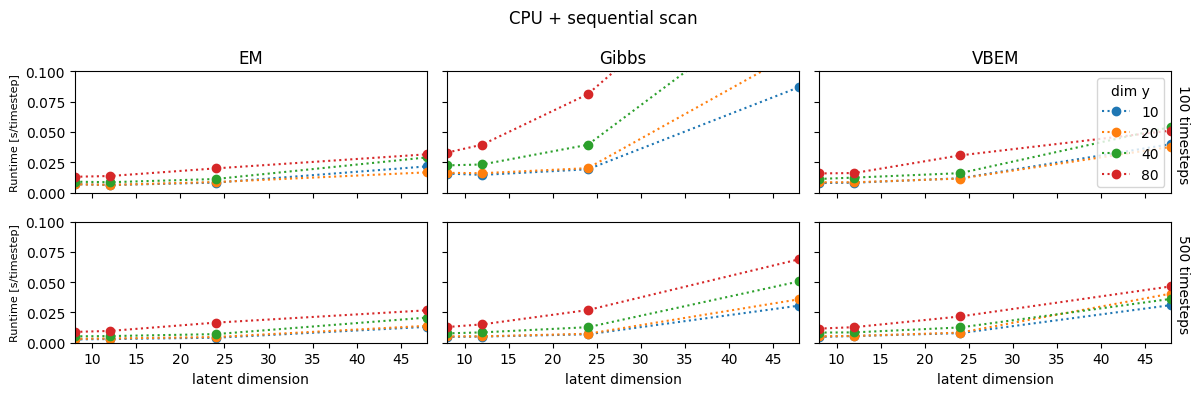

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=True, sharex=True)
algos = ['MAP-EM', 'Gibbs', 'VBEM']
for t, timesteps in enumerate([100, 500]):
    for j in range(3):
        for dim_y in [10, 20, 40, 80]:
            axes[t, j].plot([8, 12, 24, 48], [timings[(dim_y, dz, timesteps)][j] / timesteps for dz in [8, 12, 24, 48]], 'o:', label=dim_y)
            axes[0, j].set_ylim([0.0, 0.1])
            axes[1, j].set_ylim([0.0, 0.1])
            axes[0, j].set_title(algos[j])
            axes[1, j].set_xlabel('latent dimension')

axes[0, 2].legend(title='dim y')
axes[0, 0].set_ylabel('Runtime [s/timestep]', fontsize=8)
axes[1, 0].set_ylabel('Runtime [s/timestep]', fontsize=8)
axes[1, 0].set_xlim([8, 48])

axes[0, -1].text(48.5, .01, '100 timesteps', rotation=-90)
axes[1, -1].text(48.5, .01, '500 timesteps', rotation=-90)
fig.suptitle(device.upper() + ' + parallel scan' if parallel_scan else device.upper() + ' + sequential scan')
fig.tight_layout()
fig.savefig(f'{device}_benchmark_ps{int(parallel_scan)}.png', dpi=100)

## 1. Runtime comparisons with BMR

In [8]:
num_repeats = 3
timings = {}
for dim_y in [10, 20, 40, 80]:
    for dim_z in [8, 12, 24, 48]:
        for timesteps in [100, 500]:
            key, model_key = jr.split(key)
            y_obs, _, params_true = generate_data(_key, timesteps, dim_y, dim_z)

            emission_prior = MVNIG(
                jnp.zeros((dim_y, dim_z + 1)),
                precision=jnp.eye(dim_z + 1),
                alpha0=2.0,
                beta0=1.0,
                isotropic_noise=False,
            )

            dynamics_prior = MVNIG(
                jnp.zeros((dim_z, dim_z + 1)),
                precision=jnp.eye(dim_z + 1),
                alpha0=2.0,
                beta0=1.0,
                isotropic_noise=False,
            )
    
            dfa_model = BDFA(
                dim_z,
                dim_y,
                parallel_scan=parallel_scan,
                emission_prior=emission_prior,
                dynamics_prior=dynamics_prior
            )

            dfa_model.use_bmr = eqx.tree_at(lambda x: (x.emissions, x.dynamics), dfa_model.use_bmr, (True, True))

            init_params, props = dfa_model.initialize(
                model_key,
                dynamics_weights=params_true[0],
                dynamics_covariance=params_true[1],
                emission_weights=params_true[2],
                emission_covariance=params_true[3]
            )

            start = time.time()
            for _ in range(num_repeats):
                updated_params, elbos = block_until_ready(eqx.filter_jit(dfa_model.fit_em)(init_params, props, y_obs, _key, num_iters=100, verbose=False))
            end = time.time()
            mean_time1 = (end-start)/num_repeats
            
            start = time.time()
            for _ in range(num_repeats):
                block_until_ready(eqx.filter_jit(dfa_model.fit_blocked_gibbs)(_key, updated_params, props, sample_size=100, emissions=y_obs, verbose=False))
            end = time.time()
            mean_time2 = (end-start)/num_repeats

            init_params, props = dfa_model.initialize(
                model_key,
                dynamics_weights=params_true[0],
                dynamics_covariance=params_true[1],
                emission_weights=params_true[2],
                emission_covariance=params_true[3],
                variational_bayes=True
            )

            start = time.time()
            for _ in range(num_repeats):
                block_until_ready(eqx.filter_jit(dfa_model.fit_vbem)(init_params, props, y_obs, _key, num_iters=100, verbose=False))
            end = time.time()
            mean_time3 = (end-start)/num_repeats

            timings[(dim_y, dim_z, timesteps)] = (mean_time1, mean_time2, mean_time3)
            print((dim_y, dim_z, timesteps), (mean_time1, mean_time2, mean_time3))

(10, 8, 100) (2.9348768393198648, 4.405428012212117, 3.090330123901367)
(10, 8, 500) (3.585026502609253, 4.900393486022949, 4.768186887105306)
(10, 12, 100) (4.0101141929626465, 5.202686150868733, 4.302156368891398)
(10, 12, 500) (4.884450038274129, 6.331612269083659, 6.09529972076416)
(10, 24, 100) (11.635146379470825, 12.850308497746786, 12.002339124679565)
(10, 24, 500) (13.115411520004272, 14.401632388432821, 15.007672468821207)
(10, 48, 100) (92.53962961832683, 90.97669100761414, 97.3455879688263)
(10, 48, 500) (96.91688203811646, 94.49581917126973, 111.82937184969585)
(20, 8, 100) (3.2320212523142495, 4.518292586008708, 3.483225107192993)
(20, 8, 500) (4.165890137354533, 5.282099962234497, 5.080137650171916)
(20, 12, 100) (4.579396963119507, 5.943721612294515, 5.018836895624797)
(20, 12, 500) (5.783455053965251, 7.197059869766235, 7.0115493933359785)
(20, 24, 100) (14.064335028330484, 15.312601486841837, 15.16654634475708)
(20, 24, 500) (16.033580144246418, 17.313296953837078, 17

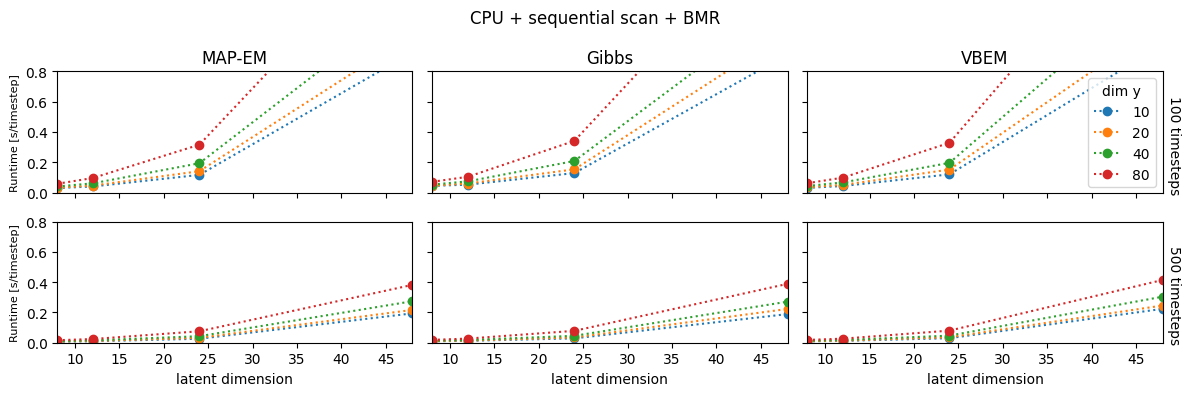

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=True, sharex=True)
algos = ['MAP-EM', 'Gibbs', 'VBEM']
for t, timesteps in enumerate([100, 500]):
    for j in range(3):
        for dim_y in [10, 20, 40, 80]:
            axes[t, j].plot([8, 12, 24, 48], [timings[(dim_y, dz, timesteps)][j] / timesteps for dz in [8, 12, 24, 48]], 'o:', label=dim_y)
            axes[0, j].set_ylim([0.0, 0.8])
            axes[1, j].set_ylim([0.0, 0.8])
            axes[0, j].set_title(algos[j])
            axes[1, j].set_xlabel('latent dimension')

axes[0, 2].legend(title='dim y')
axes[0, 0].set_ylabel('Runtime [s/timestep]', fontsize=8)
axes[1, 0].set_ylabel('Runtime [s/timestep]', fontsize=8)
axes[1, 0].set_xlim([8, 48])

axes[0, -1].text(48.5, .01, '100 timesteps', rotation=-90)
axes[1, -1].text(48.5, .01, '500 timesteps', rotation=-90)
fig.suptitle(device.upper() + ' + parallel scan + BMR' if parallel_scan else device.upper() + ' + sequential scan + BMR')
fig.tight_layout()
fig.savefig(f'{device}_benchmark_ps{int(parallel_scan)}_bmr.png', dpi=100)